Loss Value at Epoch 1100 => 0.009222: 100%|██████████| 1100/1100 [00:21<00:00, 51.59it/s]


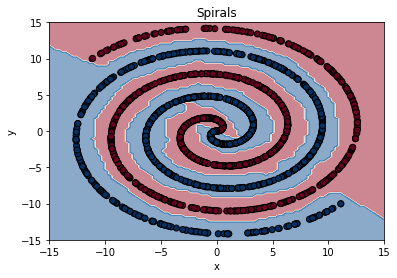

In [ ]:
# Danny Hong
# ECE 472 - Deep Learning
# Assignment 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tqdm import trange
from dataclasses import dataclass, field, InitVar

@dataclass
class Data:

  rng: InitVar[np.random.Generator]
  num_samples: int
  num_classes: int
  x: np.ndarray = field(init = False)
  y: np.ndarray = field(init = False)

  def __post_init__(self, rng):
    sigma_noise = 0.01
    self.index = np.arange(num_classes * num_samples)

    r = rng.uniform(0, 15, size = num_samples)
    t1 = r * tf.math.cos(r)
    t2 = r * tf.math.sin(r)
    noise = rng.normal(0, scale = sigma_noise, size = num_samples)
    x1 = [t1 + noise, t2 + noise]
    x2 = [(-1 * t1) + noise, (-1 * t2) + noise]

    self.x = np.concatenate([x1, x2], axis = 1).T
    self.y = np.concatenate((np.zeros(self.num_samples), np.ones(self.num_samples)))

  def get_batch(self, rng, batch_size):
    """Select random subset of examples for training batch"""
    choices = rng.choice(self.index, size = batch_size)
    return self.x[choices], self.y[choices]

class Model(tf.Module):

  def __init__(self, layers):
    self.weights = {}
    self.biases = {}
    for i, x, y in zip(range(len(layers)), layers[:-1], layers[1:]):
      weight_name = f"w{i}"
      bias_name = f"b{i}"
      self.weights[weight_name] = tf.Variable(0.2 * tf.random.normal((x, y)), name = weight_name)
      self.biases[weight_name] = tf.Variable(0.001 * tf.ones(y), name = weight_name)  

  def f(self, x):
    for weight in self.weights:
      if weight == "w0":
        self.y_hat = x @ self.weights[weight] + self.biases[weight]
      else:
        self.y_hat = tf.nn.relu(self.y_hat) @ self.weights[weight] + self.biases[weight]

    return tf.nn.sigmoid(self.y_hat)

def loss_function(y_hat, y, weights):
  alpha = 0.0001
  epsilon = 1e-15
  binary_cross_entropy = -1 * y * tf.math.log(y_hat + epsilon) - (1 - y) * tf.math.log(1 - y_hat + epsilon)
  
  l2_norm = 0
  for weight in weights:
    l2_norm = l2_norm + tf.nn.l2_loss(weights[weight])

  return (tf.reduce_mean(binary_cross_entropy + (alpha * l2_norm)))

num_samples = 1000
batch_size = 128
num_iters = 1100
num_classes = 2
random_seed = np.random.seed(31415)

def main():
  seed_sequence = np.random.SeedSequence(random_seed)
  np_seed, tf_seed = seed_sequence.spawn(2)
  np_rng = np.random.default_rng(np_seed)
  tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

  data = Data(np_rng, num_samples, num_classes)

  layers = [2, 26, 30, 34, 1]
  model = Model(layers)

  optimizer = tf.optimizers.Adam(learning_rate = 0.01)

  bar = trange(num_iters)
  for j in bar:
    with tf.GradientTape() as tape:
      x, y = data.get_batch(np_rng, batch_size)
      y_hat = tf.squeeze(model.f(x))
      loss = loss_function(y_hat, y, model.weights)

    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    bar.set_description(f"Loss Value at Epoch {j + 1} => {loss.numpy():0.6f}")
    bar.refresh()

  N = 100
  x = y = np.linspace(-15, 15, N)
  xx, yy = np.meshgrid(x, y)

  decision = np.zeros((N, N))
  for k in range(N):
    for l in range(N):
      xy = np.reshape([x[l], y[k]], (1, 2))
      p = model.f(xy)
      if p >= .5:
        decision[k, l] = 1
  
  cm = plt.cm.RdBu
  plt.contourf(xx, yy, decision, cmap = cm, alpha = 0.5)
  plt.scatter(data.x[:, 0], data.x[:, 1], c = data.y, cmap = cm, alpha = 1, edgecolors = 'black')
  plt.title("Spirals")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

main()

# I first tried to initialize the spirals based on the following link: https://conx.readthedocs.io/en/latest/Two-Spirals.html. 
# I did not get good results from this, and so I later realized that it is most likely because the r value should instead be a 
# set of data points that is picked from a uniform distribution. In regards to the loss function, I coded the binary cross 
# entropy function in order to calculate my entropy term. 

# I experimented with the alpha value (coefficient of the L2 penalty term) as well and tried out values of 0.01, 0.001, and 0.0001
# and came to the conclusion that a value of 0.0001 worked best in minimizing the loss value for me. For some reason, 
# this meant that L2 regularization was harmful to my model's accuracy since having smaller values of alpha led to better results. 

# When it came to training, I experimented with batch sizes of 16, 64, and 128. I learned that a batch size of 128 worked best, and so generally
# large batch sizes led to better results. I set the number of samples to 1000, and noticed that any value above that number didn't seem to do much
# to affect the model. In regards to the number of iterations, i experimented with iteration counts of 1000, 2000, and 3000. After around 1000 epochs, the model
# didn't seem to make much progress in learning and also led to some overfitting taking place. I found that the optimal number here 
# seems to be around 1100 epochs, which is a bit over 1000. I experimented with learning rates of 0.1, 0.01, and 0.001 and found that a learning rate
# of 0.01 worked the best for me. Finally, I experimented with the amount of hidden layers that I would be passing in to my model along with the
# amount of neurons in each layer. I experimented with multiple different combinations, and I finally 
# found a configuration that worked well: [2, 26, 30, 34, 1], consisting of 3 hidden layers each containing 26, 30, and 34 neurons respectively.
# In regards to the optimization function, I had a feeling that SGD wouldn't work well, so I tried the Adam optimization function, and that seemed
# to work well. Finally, in regards to rectifying functions, I implemented both relu and sigmoid to help improve the results. 